In [1]:
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader,TensorDataset
from tqdm import notebook
import matplotlib.pyplot as plt
from torchsummary import summary
import torch.nn.functional as F
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
device = 'mps:0' if torch.backends.mps.is_available else 'cpu'

In [3]:
start_time = '2010-01-01'
end_time   = '2024-03-31'

samsung = yf.download('005930.KS',start_time,end_time)
kospi   = yf.download('^KS11',start_time,end_time)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
samsung_=samsung.drop(columns=['Volume','Adj Close'])
samsung_mean = pd.DataFrame()
samsung_mean['mean'] = samsung_.mean(axis=1)
subtract = samsung_.apply(lambda x: x.sub(samsung_mean['mean'],axis=0))
samsung_mean_4columns = np.abs(subtract).sum(axis=1)/samsung_mean['mean']
samsung_mean_4columns

Date
2010-01-04    0.018628
2010-01-05    0.021871
2010-01-06    0.032364
2010-01-07    0.067715
2010-01-08    0.026928
                ...   
2024-03-25    0.043120
2024-03-26    0.013797
2024-03-27    0.017599
2024-03-28    0.039950
2024-03-29    0.034251
Length: 3511, dtype: float64

In [5]:
Kospi_=kospi.drop(columns=['Volume','Adj Close'])
Kospi_mean = pd.DataFrame()
Kospi_mean['mean'] = Kospi_.mean(axis=1)
subtract = Kospi_.apply(lambda x: x.sub(Kospi_mean['mean'],axis=0))
Kospi_mean_4columns = np.abs(subtract).sum(axis=1)/Kospi_mean['mean']
Kospi_mean_4columns

Date
2010-01-04    0.017088
2010-01-05    0.015891
2010-01-06    0.010714
2010-01-07    0.025920
2010-01-08    0.023117
                ...   
2024-03-25    0.018545
2024-03-26    0.013113
2024-03-27    0.009863
2024-03-28    0.007848
2024-03-29    0.010570
Length: 3509, dtype: float64

In [6]:
df_name = kospi.columns
rename = ['kospi_' + x for x in df_name]
kospi.columns = rename

In [7]:
df = pd.concat([samsung,kospi],axis=1)

In [8]:
df

,Open,High,Low,Close,Adj Close,Volume,kospi_Open,kospi_High,kospi_Low,kospi_Close,kospi_Adj Close,kospi_Volume
Date,,,,,,,,,,,,
2010-01-04,16060.0,16180.0,16000.0,16180.0,12274.592773,11950800,1681.709961,1696.140015,1681.709961,1696.140015,1696.140015,296500.0
2010-01-05,16520.0,16580.0,16300.0,16440.0,12471.834961,27925850,1701.619995,1702.390015,1686.449951,1690.619995,1690.619995,408900.0
2010-01-06,16580.0,16820.0,16520.0,16820.0,12760.113281,22948850,1697.880005,1706.890015,1696.099976,1705.319946,1705.319946,426000.0
2010-01-07,16820.0,16820.0,16260.0,16260.0,12335.280273,22107950,1702.920044,1707.900024,1683.449951,1683.449951,1683.449951,462400.0
2010-01-08,16400.0,16420.0,16120.0,16420.0,12456.662109,14777550,1694.060059,1695.260010,1668.839966,1695.260010,1695.260010,380000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-25,79600.0,79800.0,77800.0,78200.0,77500.570312,18703996,2756.590088,2763.629883,2731.699951,2737.570068,2737.570068,489600.0
2024-03-26,79700.0,80100.0,79200.0,79900.0,79185.359375,30551494,2756.419922,2779.399902,2752.270020,2757.090088,2757.090088,448300.0
2024-03-27,79200.0,80000.0,79200.0,79800.0,79086.257812,17424595,2745.000000,2762.030029,2745.000000,2755.110107,2755.110107,510600.0


In [9]:
df['fluctuation']       = samsung_mean_4columns
df['kospi_fluctuation'] = Kospi_mean_4columns

In [10]:
df

,Open,High,Low,Close,Adj Close,Volume,kospi_Open,kospi_High,kospi_Low,kospi_Close,kospi_Adj Close,kospi_Volume,fluctuation,kospi_fluctuation
Date,,,,,,,,,,,,,,
2010-01-04,16060.0,16180.0,16000.0,16180.0,12274.592773,11950800,1681.709961,1696.140015,1681.709961,1696.140015,1696.140015,296500.0,0.018628,0.017088
2010-01-05,16520.0,16580.0,16300.0,16440.0,12471.834961,27925850,1701.619995,1702.390015,1686.449951,1690.619995,1690.619995,408900.0,0.021871,0.015891
2010-01-06,16580.0,16820.0,16520.0,16820.0,12760.113281,22948850,1697.880005,1706.890015,1696.099976,1705.319946,1705.319946,426000.0,0.032364,0.010714
2010-01-07,16820.0,16820.0,16260.0,16260.0,12335.280273,22107950,1702.920044,1707.900024,1683.449951,1683.449951,1683.449951,462400.0,0.067715,0.025920
2010-01-08,16400.0,16420.0,16120.0,16420.0,12456.662109,14777550,1694.060059,1695.260010,1668.839966,1695.260010,1695.260010,380000.0,0.026928,0.023117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-25,79600.0,79800.0,77800.0,78200.0,77500.570312,18703996,2756.590088,2763.629883,2731.699951,2737.570068,2737.570068,489600.0,0.043120,0.018545
2024-03-26,79700.0,80100.0,79200.0,79900.0,79185.359375,30551494,2756.419922,2779.399902,2752.270020,2757.090088,2757.090088,448300.0,0.013797,0.013113
2024-03-27,79200.0,80000.0,79200.0,79800.0,79086.257812,17424595,2745.000000,2762.030029,2745.000000,2755.110107,2755.110107,510600.0,0.017599,0.009863


In [11]:
df.mean()

Open                 4.165784e+04
High                 4.203821e+04
Low                  4.125945e+04
Close                4.164281e+04
Adj Close            3.653969e+04
Volume               1.467664e+07
kospi_Open           2.201338e+03
kospi_High           2.211649e+03
kospi_Low            2.188031e+03
kospi_Close          2.200160e+03
kospi_Adj Close      2.200160e+03
kospi_Volume         4.963545e+05
fluctuation          3.012735e-02
kospi_fluctuation    1.671108e-02
dtype: float64

In [12]:
df = df.fillna(df.mean())

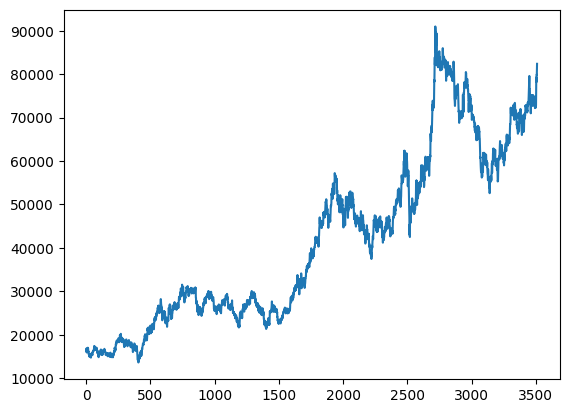

In [13]:
plt.plot(np.arange(len(df)),df['Close'])

In [14]:
label_number = np.arange(0,10)
label_list   = []

In [15]:
label_np= np.zeros(len(df))

for i in range(1,len(df)):
    label_np[i] = np.where(df['Close'].iloc[i]>df['Close'].iloc[i-1],1,0)

In [16]:
df['label']=label_np

In [17]:
df['label']

Date
2010-01-04    0.0
2010-01-05    1.0
2010-01-06    1.0
2010-01-07    0.0
2010-01-08    1.0
             ... 
2024-03-25    0.0
2024-03-26    1.0
2024-03-27    0.0
2024-03-28    1.0
2024-03-29    1.0
Name: label, Length: 3511, dtype: float64

In [18]:
df

,Open,High,Low,Close,Adj Close,Volume,kospi_Open,kospi_High,kospi_Low,kospi_Close,kospi_Adj Close,kospi_Volume,fluctuation,kospi_fluctuation,label
Date,,,,,,,,,,,,,,,
2010-01-04,16060.0,16180.0,16000.0,16180.0,12274.592773,11950800,1681.709961,1696.140015,1681.709961,1696.140015,1696.140015,296500.0,0.018628,0.017088,0.0
2010-01-05,16520.0,16580.0,16300.0,16440.0,12471.834961,27925850,1701.619995,1702.390015,1686.449951,1690.619995,1690.619995,408900.0,0.021871,0.015891,1.0
2010-01-06,16580.0,16820.0,16520.0,16820.0,12760.113281,22948850,1697.880005,1706.890015,1696.099976,1705.319946,1705.319946,426000.0,0.032364,0.010714,1.0
2010-01-07,16820.0,16820.0,16260.0,16260.0,12335.280273,22107950,1702.920044,1707.900024,1683.449951,1683.449951,1683.449951,462400.0,0.067715,0.025920,0.0
2010-01-08,16400.0,16420.0,16120.0,16420.0,12456.662109,14777550,1694.060059,1695.260010,1668.839966,1695.260010,1695.260010,380000.0,0.026928,0.023117,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-25,79600.0,79800.0,77800.0,78200.0,77500.570312,18703996,2756.590088,2763.629883,2731.699951,2737.570068,2737.570068,489600.0,0.043120,0.018545,0.0
2024-03-26,79700.0,80100.0,79200.0,79900.0,79185.359375,30551494,2756.419922,2779.399902,2752.270020,2757.090088,2757.090088,448300.0,0.013797,0.013113,1.0
2024-03-27,79200.0,80000.0,79200.0,79800.0,79086.257812,17424595,2745.000000,2762.030029,2745.000000,2755.110107,2755.110107,510600.0,0.017599,0.009863,0.0


In [19]:
df.shape

(3511, 15)

In [20]:
class NN_and_data(nn.Module):
    def __init__(self,seq_len,batch_size,lr,epochs,data_file
                 ,each_epoch):
        super(NN_and_data,self).__init__()
        
        self.seq_len     = seq_len
        self.batch_size  = batch_size 
        self.datafile    = data_file


        
        
        self.Conv1   = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=(2,3))
        self.flatten = nn.Flatten()
        self.fc1     = nn.Linear(32*2*12,1)

        
    def Make_window_Data(self):
        privious_day = []
        nextday      = []
        scaler       = MinMaxScaler()
        for index in range(len(self.datafile)-self.seq_len):

            seq_len_data = self.datafile.iloc[index:index+seq_len,:-1]
            next_data    = self.datafile.iloc[index+seq_len,-1]

            sc_seq_len_data = scaler.fit_transform(seq_len_data)

            privious_day.append(sc_seq_len_data)
            nextday.append(next_data)
        return np.array(privious_day),np.array(nextday)

    def Data_and_DataLoader(self):
        x,y      = NN_and_data.Make_window_Data(self)
        
        train_x,test_x,train_y,test_y =  train_test_split(x,y,test_size=0.07,shuffle=False)
        
        train_x = torch.FloatTensor(train_x)
        train_y = torch.FloatTensor(train_y)
        test_x  = torch.FloatTensor(test_x)
        test_y  = torch.FloatTensor(test_y)
        train_x = train_x.view(len(train_x),1,self.seq_len,train_x.shape[-1])
        test_x  = test_x.view(len(test_x),1,self.seq_len,test_x.shape[-1])
        Train_datasets  = TensorDataset(train_x,train_y)
        Test_datasets   = TensorDataset(test_x,test_y)
        
            
        Train_Data_Loader = torch.utils.data.DataLoader(dataset=Train_datasets,batch_size = self.batch_size,
                                                        shuffle = False)
        
        Test_Data_Loader  = torch.utils.data.DataLoader(dataset=Test_datasets,batch_size = self.batch_size,
                                                        shuffle = False)
        return Train_Data_Loader,Test_Data_Loader,test_x,test_y        
        

        
    def forward(self,x):

        x = self.Conv1(x)

        
        x = F.relu(x)
        
        x = self.flatten(x)
        
#         print(x.size())
        
#         x = self.fc1(x)

#         x = F.sigmoid(x)
        
#         print(x[0])
        return x
    
    

In [21]:
class Train_Predict():
    
    def __init__(self,epochs,data_file,each_epoch,seq_len,Data_Loader,criterion):
        
        super(Train_Predict,self).__init__()
        
        self.each_epoch  = each_epoch
        self.lr          = lr
        self.epochs      = epochs
        self.seq_len     = seq_len
        self.Data_Loader = Data_Loader 
        self.criterion   = criterion 
        
    def Training(self):

        optimizer = optim.Adam(model.parameters(),lr=self.lr)
        model.train()

        loss_list = np.zeros(self.epochs)
        check_point = 0
        for i in notebook.tqdm(range(self.epochs)):
            
            avg_loss = 0
            length   = len(self.Data_Loader)

            for data,target in self.Data_Loader:
                
                target      = target.view(-1,1)
#                 data,target = data.to(device),target.to(device)

                optimizer.zero_grad()

                output = model(data)
                
   
                loss   = self.criterion(output,target)
                loss.backward()
                optimizer.step()
                avg_loss += loss.item()/length
                loss_list[i]  = avg_loss

                
            if i%self.each_epoch == 0 and i!=0:
                
                print(i,avg_loss)
                
#                 torch.save({'model':'model','epoch':self.epochs,
#                            'model_state_dict':model.state_dict(),
#                            'optimzer_state_dict':optimizer.state_dict(),
#                            'avg_loss':avg_loss,
#                            'check_point':f'custommodel_check_point - {check_point}'
#                            },f'./save/model_{seq_len}_splited_samsung-{check_point}_CNN_kospi.pt')
#                 check_point +=1 
                
                if loss_list[i-each_epoch]<loss_list[i]:
                    
                    torch.save({'model':'model','epoch':self.epochs,
                   'model_state_dict':model.state_dict(),
                   'optimzer_state_dict':optimizer.state_dict(),
                   'loss_list':loss_list,
                   },f'./save/model_{seq_len}_splited_samsung_CNN_kospi.pt')
                    break 
#         torch.save(model,f'./{model}_{seq_len}_splited_apple.pt')
        torch.save({'model':'model','epoch':self.epochs,
               'model_state_dict':model.state_dict(),
               'optimzer_state_dict':optimizer.state_dict(),
               'loss_list':loss_list,
               },f'./save/model_{seq_len}_splited_samsung_CNN_kospi.pt')

        return loss_list

#     def predict(self):

#         model.eval().to(device)
#         test_loss = 0
#         correct   =0

#         with torch.no_grad():

#             for index,(data,label) in enumerate(self.Data_Loader):

#                 data=data.to(device)
#                 label=label.to(device).view(-1,1)

#                 output     = model(data)
#                 test_loss += criterion(output,label).item()
#                 pred       = torch.where(output<0.5,0,1)


#                 correct += pred.eq(label.view_as(pred)).sum().item()

#         accuracy = (100 * correct)/len(self.Data_Loader.dataset)
        
    def predict(self):

        model.eval()
        test_loss = 0
        correct   = 0 
        pred_list = []
        with torch.no_grad():

#             test_x=test_x.to(device)
#             test_y=test_y.view(-1,1)
            output     = model(test_x)
#             test_loss += criterion(test_x,test_y).item()
            pred       = torch.where(output<0.5,0,1)


            correct    += pred.eq(test_y.view_as(pred)).sum().item()
#             pred_list.append((np.array(pred)).item())
            pred_nump = pred.squeeze().numpy()
        accuracy = (100 * correct)/len(self.Data_Loader.dataset)    
    
        return output,accuracy,pred_nump

In [22]:
class NN_and_data_(nn.Module):
    def __init__(self,seq_len,batch_size,lr,epochs,data_file
                 ,each_epoch,x_size):
        super(NN_and_data_,self).__init__()
        
        self.seq_len     = seq_len
        self.batch_size  = batch_size 
        self.datafile    = data_file


        
        
        self.Conv1   = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=(2,3))
        self.flatten = nn.Flatten()
        self.fc1     = nn.Linear(x_size,1)

        
    def Make_window_Data(self):
        privious_day = []
        nextday      = []
        scaler       = MinMaxScaler()
        for index in range(len(self.datafile)-self.seq_len):

            seq_len_data = self.datafile.iloc[index:index+seq_len,:-1]
            next_data    = self.datafile.iloc[index+seq_len,-1]

            sc_seq_len_data = scaler.fit_transform(seq_len_data)

            privious_day.append(sc_seq_len_data)
            nextday.append(next_data)
        return np.array(privious_day),np.array(nextday)

    def Data_and_DataLoader(self):
        x,y      = NN_and_data.Make_window_Data(self)
        
        train_x,test_x,train_y,test_y =  train_test_split(x,y,test_size=0.07,shuffle=False)
        
        train_x = torch.FloatTensor(train_x)
        train_y = torch.FloatTensor(train_y)
        test_x  = torch.FloatTensor(test_x)
        test_y  = torch.FloatTensor(test_y)
        train_x = train_x.view(len(train_x),1,self.seq_len,train_x.shape[-1])
        test_x  = test_x.view(len(test_x),1,self.seq_len,test_x.shape[-1])
        Train_datasets  = TensorDataset(train_x,train_y)
        Test_datasets   = TensorDataset(test_x,test_y)
        
            
        Train_Data_Loader = torch.utils.data.DataLoader(dataset=Train_datasets,batch_size = self.batch_size,
                                                        shuffle = False)
        
        Test_Data_Loader  = torch.utils.data.DataLoader(dataset=Test_datasets,batch_size = self.batch_size,
                                                        shuffle = False)
        return Train_Data_Loader,Test_Data_Loader,test_x,test_y        
        

        
    def forward(self,x):

        x = self.Conv1(x)

        
        x = F.relu(x)

        x = self.flatten(x)
        
        
        x = self.fc1(x)

        x = F.sigmoid(x)
        
#         print(x[0])
        return x
    
    

In [23]:
# def predict(self):
    
#     model.eval().to(device)
#     test_loss = 0
#     correct   =0


#     with torch.no_grad():

      

#     data=data.to(device)
#     label=label.to(device).view(-1,1)

#     output     = model(data)
#     test_loss += criterion(output,label).item()
#     pred       = torch.where(output<0.5,0,1)


#     correct += pred.eq(label.view_as(pred)).sum().item()

#     accuracy = (100 * correct)/len(self.Data_Loader.dataset)

In [24]:
seq_len     = 3
batch_size  = 16
lr          = 1e-4
epochs      = 10000
each_epoch  = 100
data_file   = df
criterion   = nn.BCELoss()

  0%|          | 0/10000 [00:00<?, ?it/s]

100 0.6708649060889785
200 0.6616919443887822
300 0.6550961507886062
400 0.649845820139436
500 0.6453011301802652
600 0.641414964754208
700 0.637935701976804
800 0.6348089195933997
900 0.631893916749487
1000 0.6291484248404412
1100 0.6266568614279524
1200 0.6242594333255993
1300 0.6220811478355349
1400 0.6199871769138411
1500 0.6179897307473071
1600 0.6160341169612078
1700 0.6141381988338398
1800 0.6123113581070709
1900 0.6105075836473822
2000 0.6086472619105786
2100 0.6068227137712869
2200 0.6050552480361046
2300 0.6033359998289275
2400 0.6016911088543779
2500 0.6000667066842904
2600 0.5984835122145861
2700 0.5969111541030451
2800 0.5953677122791607
2900 0.5938497644429114
3000 0.592373391430752
3100 0.5909402680163289
3200 0.5895709518124076
3300 0.5882587931027597
3400 0.5869898636843645
3500 0.5857402784567252
3600 0.5844866319322118
3700 0.5832237943130381
3800 0.5819666512748771
3900 0.5807585538017982
4000 0.579518128697779
4100 0.5782489065153924
4200 0.577038788181894
4300 0.5

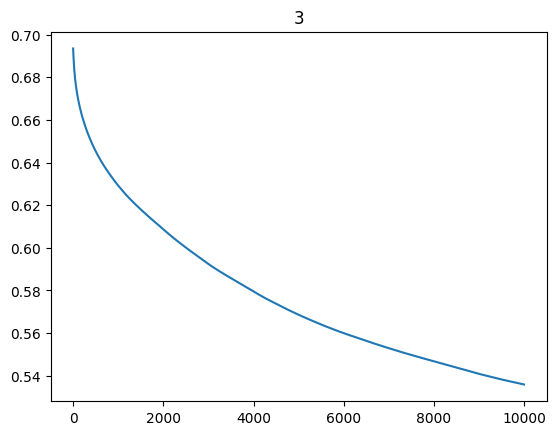

  0%|          | 0/10000 [00:00<?, ?it/s]

100 0.6647114224878018
200 0.6487250255019055
300 0.6355377181487928
400 0.6245430535545533
500 0.6152452959441674
600 0.6071530425665421
700 0.5998296926126759
800 0.5933363371912166
900 0.5873971645738564
1000 0.581936950923181
1100 0.5768256920809839
1200 0.5720260014720991
1300 0.5674393894333468
1400 0.5631688308774255
1500 0.5591124183699197
1600 0.5553065887561031
1700 0.5517021795990421
1800 0.5482642390564372
1900 0.5448714528305857
2000 0.5415667713272807
2100 0.5384432467467641
2200 0.5354093247476748
2300 0.532484629574944
2400 0.5296540139060392
2500 0.5269174694138415
2600 0.5242534843729991
2700 0.5216764096243708
2800 0.5191564145041448
2900 0.5167007253450504
3000 0.5142247305781233
3100 0.5116000264590862
3200 0.5090176875100416
3300 0.5065734091342664
3400 0.5042322399277311
3500 0.5018930277403661
3600 0.4996240790568145
3700 0.49745117770690533
3800 0.4952862828093416
3900 0.49320397774378427
4000 0.4911699173789398
4100 0.48914882073215404
4200 0.48715617010990786

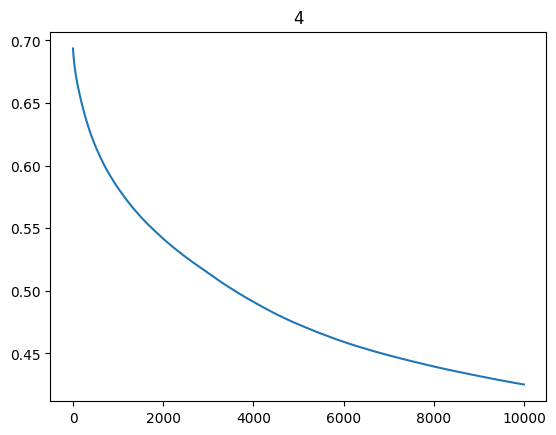

  0%|          | 0/10000 [00:00<?, ?it/s]

100 0.6607730660368413
200 0.6421804086250419
300 0.6273087352222083
400 0.6150586385937301
500 0.6044161278827513
600 0.5949171899872668
700 0.5861938563632032
800 0.5780188881006898
900 0.5704726087404232
1000 0.5634972419516715
1100 0.5568521764932896
1200 0.5505781309569582
1300 0.5445413975154655
1400 0.5388398263968673
1500 0.5332095016743621
1600 0.5278545070220443
1700 0.5227375895369287
1800 0.5178201572567807
1900 0.5131012397069558
2000 0.5085773934044092
2100 0.5042197271889329
2200 0.5000173690564493
2300 0.4959259171988451
2400 0.49189719017229844
2500 0.48792423906863885
2600 0.48402909992956644
2700 0.48026045499479086
2800 0.47653465060626743
2900 0.47297142709002765
3000 0.4695301162553768
3100 0.46619999934645234
3200 0.46297783623723415
3300 0.45976990227605785
3400 0.4566509362091034
3500 0.4535982760728573
3600 0.4506261649669386
3700 0.44775199364213375
3800 0.44495522683742
3900 0.4422398295764831
4000 0.43958570596342
4100 0.4369819083926725
4200 0.434429353723

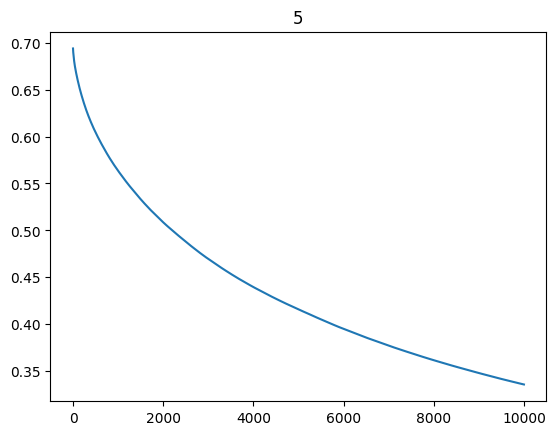

  0%|          | 0/10000 [00:00<?, ?it/s]

100 0.6541098236453303
200 0.6328991265857921
300 0.6160976984629446
400 0.6017408718665441
500 0.5887176660346051
600 0.5767656330968821
700 0.5657151689132056
800 0.5556094127835007
900 0.5462373334403132
1000 0.5374702203507515
1100 0.5292606876761304
1200 0.5215023542736092
1300 0.5141765894550901
1400 0.5071881262987268
1500 0.5004607735603464
1600 0.4940142377334483
1700 0.4878060765126173
1800 0.48179308164353457
1900 0.4759836028896128
2000 0.4704134145788121
2100 0.4650033769362114
2200 0.4597204665050788
2300 0.4546173914682631
2400 0.4496642300019077
2500 0.44481314733332267
2600 0.4401420785808096
2700 0.435557330063745
2800 0.4311402999595099
2900 0.4268368557095527
3000 0.4226637305144003
3100 0.41856940821105354
3200 0.4145735967539105
3300 0.410642781751413
3400 0.4067357526544261
3500 0.40292280612915166
3600 0.3991306489881348
3700 0.395408551701728
3800 0.3918155187777444
3900 0.38832572913345176
4000 0.3849033418969781
4100 0.381558182558008
4200 0.3783063713242025


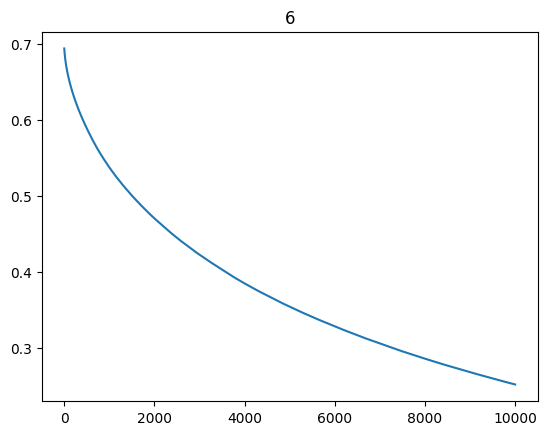

  0%|          | 0/10000 [00:00<?, ?it/s]

100 0.6548748831538589
200 0.6320260059015422
300 0.6137910254445726
400 0.598305538588879
500 0.5846089342353389
600 0.5722099168627868
700 0.5605863616162655
800 0.5496894863306306
900 0.5394085328660758
1000 0.5296594843852754
1100 0.520321869528761
1200 0.5114204440923299
1300 0.50290352398274
1400 0.49478821777829973
1500 0.48695082611897417
1600 0.4794030658462469
1700 0.4720784561599003
1800 0.46502032934450643
1900 0.4582080477300812
2000 0.45163235813379277
2100 0.4452169171589261
2200 0.43892832100391405
2300 0.4327996145276461
2400 0.42683819053219824
2500 0.4209916054033765
2600 0.41534947545505013
2700 0.4097813391948444
2800 0.40436337610670164
2900 0.39907757915994707
3000 0.3937843723186091
3100 0.38869871206435513
3200 0.3837488037990589
3300 0.378882654449519
3400 0.3741100154378835
3500 0.36942711684341534
3600 0.3648932859593746
3700 0.36046614855820064
3800 0.35615475271262365
3900 0.3519167501260252
4000 0.3477932215467387
4100 0.34377575789888687
4200 0.339819475

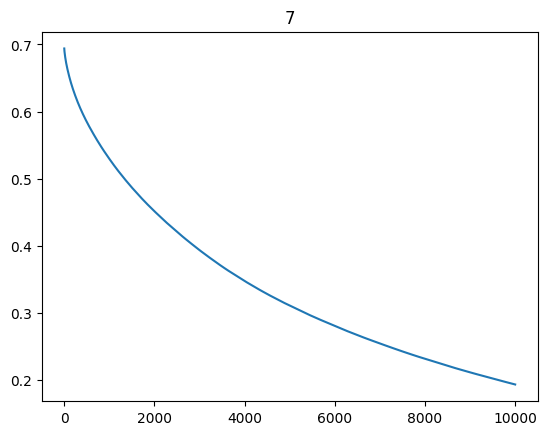

  0%|          | 0/10000 [00:00<?, ?it/s]

100 0.6451689980778041
200 0.6149478575178224
300 0.5913090917701818
400 0.5716128977490408
500 0.554204478421632
600 0.5386488605655875
700 0.5244920031697144
800 0.5114337809237781
900 0.4991793048148064
1000 0.48764452674225256
1100 0.47646882092835857
1200 0.4658495320701132
1300 0.4557802365252785
1400 0.44621573439707946
1500 0.43703773858792627
1600 0.4282510895647254
1700 0.4198477062962801
1800 0.4117184423786751
1900 0.4037823105121359
2000 0.3960666113040028
2100 0.38865437073742654
2200 0.3814949669382154
2300 0.3744808999346749
2400 0.3676476900045779
2500 0.36099433285348553
2600 0.35452321675770426
2700 0.3481999161634958
2800 0.34208664480669837
2900 0.33611029510696727
3000 0.3302775756547263
3100 0.32456625136090256
3200 0.31897210110636337
3300 0.3134941617209538
3400 0.30811154981162026
3500 0.3028631205944452
3600 0.29773342996543506
3700 0.29270937454466717
3800 0.28778958276790734
3900 0.282964456388179
4000 0.2782406270065727
4100 0.273600090915958
4200 0.269073

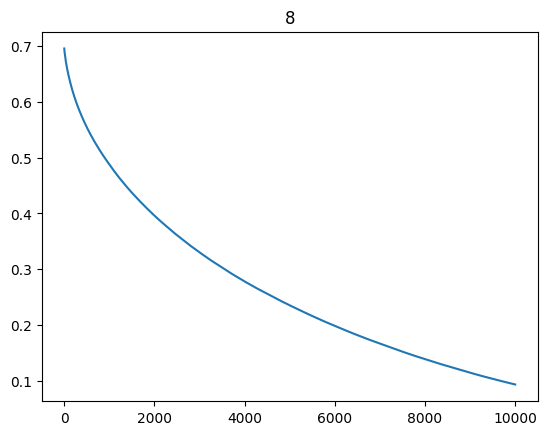

  0%|          | 0/10000 [00:00<?, ?it/s]

100 0.6424383748980128
200 0.6115461615662949
300 0.5876643023654526
400 0.5672171269269548
500 0.5487759437631159
600 0.5321527240323087
700 0.5169421042881762
800 0.5027904738398158
900 0.48949599704321684
1000 0.476996543652871
1100 0.4651029627112784
1200 0.4537737500287742
1300 0.44296380709491534
1400 0.4325994790769091
1500 0.42267247325941626
1600 0.41317587097485853
1700 0.40399097943422846
1800 0.395132971891001
1900 0.3865787387624678
2000 0.3782456525254485
2100 0.37012151716386565
2200 0.36223163769817807
2300 0.3545538863422823
2400 0.3470540851646779
2500 0.3397362427968603
2600 0.33262949268899705
2700 0.325687473165054
2800 0.31893538924701065
2900 0.31234498752974993
3000 0.30591261036255785
3100 0.29962660083729836
3200 0.2934638191671934
3300 0.2873825133942507
3400 0.28141362804408154
3500 0.27557659196649104
3600 0.26984052739891345
3700 0.2642436069892901
3800 0.2587668935165685
3900 0.2533943196210791
4000 0.24812631403990829
4100 0.2429601409856011
4200 0.23786

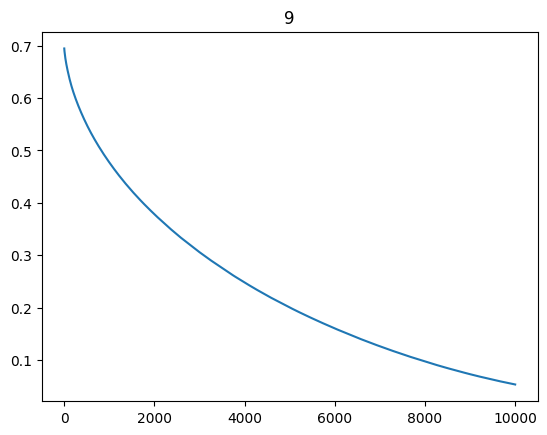

In [62]:

seq_list      = np.arange(3,10)
accuracy_list = []
pred_dic      = {}

for i in seq_list:
    
    seq_len = i
    
    model   = NN_and_data(seq_len,batch_size,lr,epochs,data_file
                 ,each_epoch)
    
    Train_Data_Loader,Test_Data_Loader,test_x,test_y = model.Data_and_DataLoader()
    x_size = model(test_x)
    
    model   = NN_and_data_(seq_len,batch_size,lr,epochs,data_file
                 ,each_epoch,x_size.size(-1))
    
    
    train_tool = Train_Predict(epochs,data_file,each_epoch,seq_len,Train_Data_Loader,criterion)
    loss       = train_tool.Training()
    plt.plot(loss)
    plt.title(f'{i}')
    plt.show()
    
    test_tool = Train_Predict(epochs,data_file,each_epoch,seq_len,Test_Data_Loader,criterion)
    
    accuracy,pred_numpy = test_tool.predict()

    pred_dic[i] = pred_numpy
    accuracy_list.append(accuracy)


In [65]:
# torch.save(pred_dic,f'./pred_samsung_CNN,kospi')

In [ ]:
for x,y in Train_Data_Loader:
    break
print(x.size())

In [ ]:
seq_len=np.arange(3,10)

In [ ]:
accuracy_list

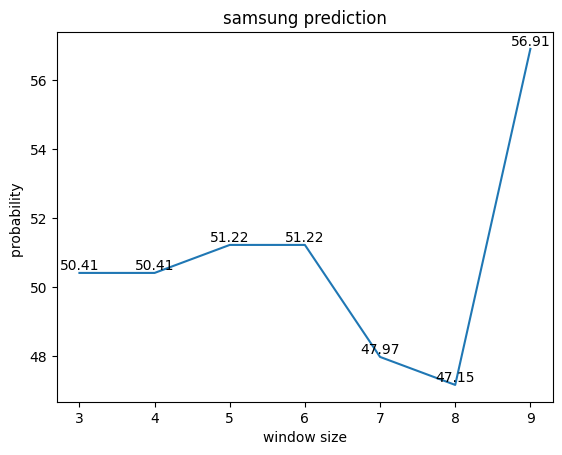

In [66]:
plt.plot(seq_list,accuracy_list)
for i in range(len(accuracy_list)):
    height = round(accuracy_list[i],2)
    plt.text (seq_list[i],height,height, ha='center', va='bottom')
plt.title('samsung prediction')
plt.xlabel('window size')
plt.ylabel('probability ')
plt.show()

In [29]:
# torch.save(accuracy_lst,'./pred_samsung_add_cnn,kospi')

In [83]:
seq_len = 3 
model   = NN_and_data(seq_len,batch_size,lr,epochs,data_file
             ,each_epoch)


Train_Data_Loader,Test_Data_Loader,test_x,test_y = model.Data_and_DataLoader()

x_size = model(test_x)

model   = NN_and_data_(seq_len,batch_size,lr,epochs,data_file
             ,each_epoch,x_size.size(-1))
    
save_file = torch.load(f'./save/model_{seq_len}_splited_samsung_CNN_kospi.pt')

model.load_state_dict(save_file['model_state_dict'])

test_tool = Train_Predict(epochs,data_file,each_epoch,seq_len,Test_Data_Loader,criterion)


In [85]:
output,accuracy,pred_numpy = test_tool.predict()

In [87]:
print(output.shape)

torch.Size([246, 1])


In [88]:
result = []
for i in range(len(output)):
    if output[i]>=0.8:
        result.append(output[i])

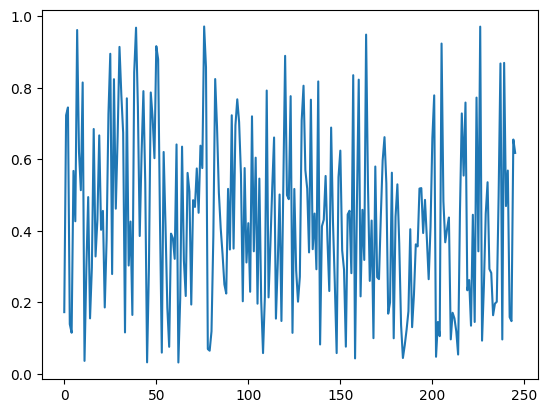

In [92]:
plt.plot(output)
plt.show()

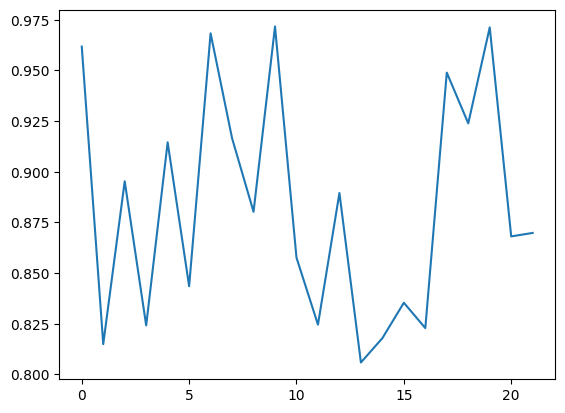

In [90]:
plt.plot(result)
plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

100 0.6307481109511622
200 0.594636581545951
300 0.5659913165020009
400 0.5413617864251139
500 0.5192952782792203
600 0.4991406734083216
700 0.4804913490718485
800 0.4631482501532514
900 0.446923654672562
1000 0.4315649181896567
1100 0.4169361377317533
1200 0.4029030664002193
1300 0.3894514299783054
1400 0.37654616464586804
1500 0.36414348304856076
1600 0.35224692581915384
1700 0.3408210416342699
1800 0.32977254411169116
1900 0.3190705031886989
2000 0.30871760070908283
2100 0.29864221614073294
2200 0.2887848827111369
2300 0.279265234648597
2400 0.27003992703177176
2500 0.2610855468128827
2600 0.2523199910407556
2700 0.24376221811946713
2800 0.23542020444338232
2900 0.22731567031758673
3000 0.2194010100016991
3100 0.2116631507946581
3200 0.2041594147609146
3300 0.19684126677320285
3400 0.1897101904831681
3500 0.18274873199270067
3600 0.17596081710037062
3700 0.16930801961936212
3800 0.16284392708364656
3900 0.1565561589291867
4000 0.15046630776030753
4100 0.14454651550919395
4200 0.1387

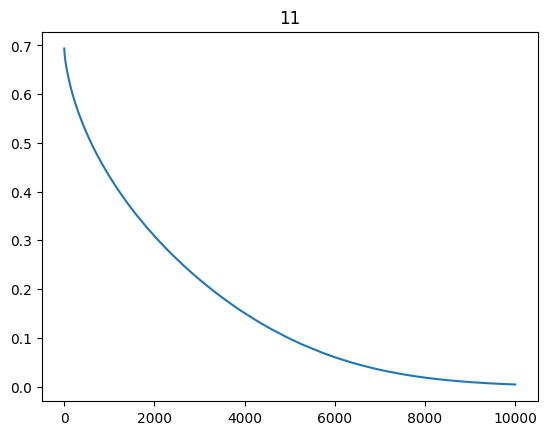

  0%|          | 0/10000 [00:00<?, ?it/s]

100 0.6314219112197558
200 0.5931951701641084
300 0.5624667975832437
400 0.536107546704657
500 0.512406431576785
600 0.49059297757990217
700 0.4701796990691451
800 0.45114316272677174
900 0.4332116566890595
1000 0.41623429099426534
1100 0.4001458863563398
1200 0.38479255161741205
1300 0.37014130327631445
1400 0.3561575636267663
1500 0.3427435553395282
1600 0.3298982515492859
1700 0.31759310455298895
1800 0.305670289322734
1900 0.2940869914988676
2000 0.2829223590008185
2100 0.27210671586148877
2200 0.2616375309652557
2300 0.2515187578677547
2400 0.24170269579717932
2500 0.2321522814751256
2600 0.22289902640177917
2700 0.21387180295206754
2800 0.20509048281054873
2900 0.19650789613232894
3000 0.18819511975800876
3100 0.18009379885944674
3200 0.17219229674368502
3300 0.16451632341041286
3400 0.1570691448435481
3500 0.14985312609111562
3600 0.1428680748258736
3700 0.13608516086185093
3800 0.1295180884098598
3900 0.12315593411525093
4000 0.11700836901425146
4100 0.11106074889939206
4200 0.

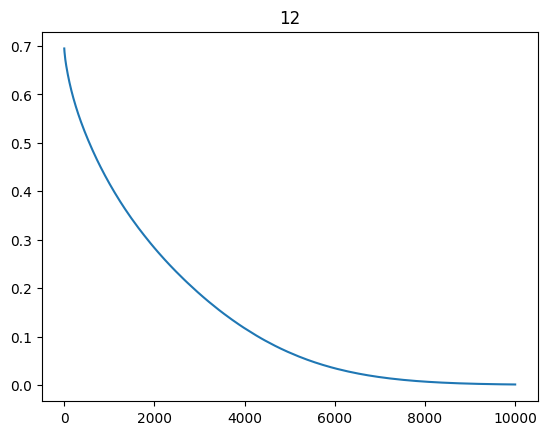

  0%|          | 0/10000 [00:00<?, ?it/s]

100 0.6331748391191165
200 0.5955123917437065
300 0.5652479752898217
400 0.5392128346013084
500 0.5160047067877127
600 0.49468774297365964
700 0.47476234608421114
800 0.45606204217263296
900 0.438200515201863
1000 0.42124639867859753
1100 0.40514294730097633
1200 0.38975403392139596
1300 0.37499206987958345
1400 0.360891777547259
1500 0.3473795974152345
1600 0.33440460527644444
1700 0.3219394074643361
1800 0.3099857874068559
1900 0.2984688854685017
2000 0.28735213726758957
2100 0.2766308077775383
2200 0.2662596679566539
2300 0.25620891926262307
2400 0.24647506907144004
2500 0.23704843036830417
2600 0.22793127558029755
2700 0.21912222067076798
2800 0.2105871193731823
2900 0.20230769207153237
3000 0.19429205851081557
3100 0.1864988733923027
3200 0.17892365362129956
3300 0.17156509059828293
3400 0.16437650886455593
3500 0.1573838907494848
3600 0.15059744349370394
3700 0.1439782158909913
3800 0.13755900698586127
3900 0.13130481522895546
4000 0.12524225166542277
4100 0.11936628374764148
420

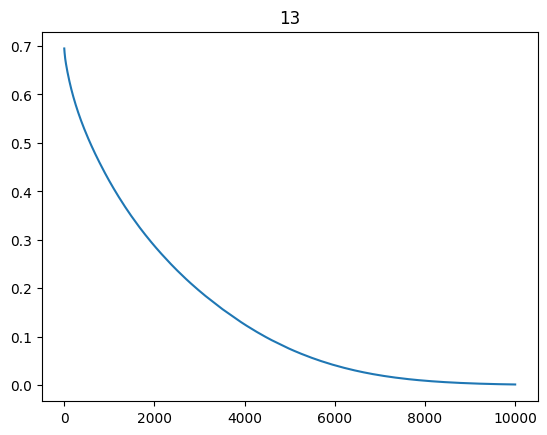

In [25]:
seq_list      = np.arange(11,14)
accuracy_list_ = []
pred_dic_      = {}

for i in seq_list:
    
    seq_len = i
    
    model   = NN_and_data(seq_len,batch_size,lr,epochs,data_file
                 ,each_epoch)
    
    Train_Data_Loader,Test_Data_Loader,test_x,test_y = model.Data_and_DataLoader()
    x_size = model(test_x)
    
    model   = NN_and_data_(seq_len,batch_size,lr,epochs,data_file
                 ,each_epoch,x_size.size(-1))
    
    
    train_tool = Train_Predict(epochs,data_file,each_epoch,seq_len,Train_Data_Loader,criterion)
    loss       = train_tool.Training()
    plt.plot(loss)
    plt.title(f'{i}')
    plt.show()
    
    test_tool = Train_Predict(epochs,data_file,each_epoch,seq_len,Test_Data_Loader,criterion)
    
    output,accuracy,pred_numpy = test_tool.predict()

    pred_dic_[i] = pred_numpy
    accuracy_list_.append(accuracy)

In [37]:
seq_len = 10
model   = NN_and_data(seq_len,batch_size,lr,epochs,data_file
             ,each_epoch)


Train_Data_Loader,Test_Data_Loader,test_x,test_y = model.Data_and_DataLoader()

x_size = model(test_x)

model   = NN_and_data_(seq_len,batch_size,lr,epochs,data_file
             ,each_epoch,x_size.size(-1))
    
save_file = torch.load(f'./save/model_{seq_len}_splited_samsung_CNN_kospi.pt')

model.load_state_dict(save_file['model_state_dict'])

test_tool = Train_Predict(epochs,data_file,each_epoch,seq_len,Test_Data_Loader,criterion)

output,accuracy_10,pred_numpy = test_tool.predict()


In [38]:
accuracy_10

50.8130081300813

In [ ]:
seq_list_ = np.arange(3,14)
for i in seq_list_:
    

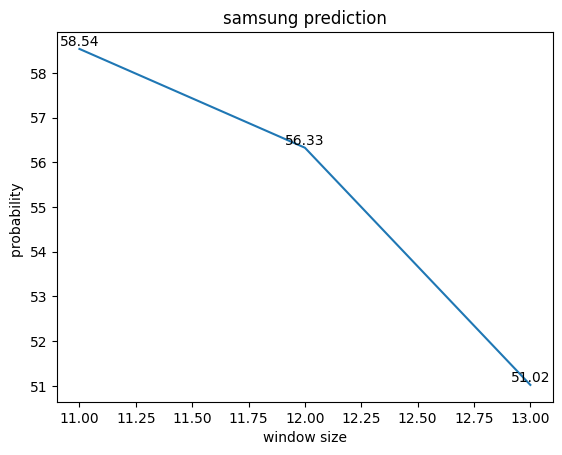

In [26]:
plt.plot(seq_list_,accuracy_list_)
for i in range(len(accuracy_list_)):
    height = round(accuracy_list_[i],2)
    plt.text (seq_list[i],height,height, ha='center', va='bottom')
plt.title('samsung prediction')
plt.xlabel('window size')
plt.ylabel('probability ')
plt.show()

In [25]:
seq_list     = np.arange(3,14)
accuracy_lst = []

for i in seq_list:
    seq_len = i 
    
    model   = NN_and_data(i,batch_size,lr,epochs,data_file
                 ,each_epoch)


    Train_Data_Loader,Test_Data_Loader,test_x,test_y = model.Data_and_DataLoader()

    x_size = model(test_x)

    model   = NN_and_data_(i,batch_size,lr,epochs,data_file
                 ,each_epoch,x_size.size(-1))

    save_file = torch.load(f'./save/model_{seq_len}_splited_samsung_CNN_kospi.pt')

    model.load_state_dict(save_file['model_state_dict'])

    test_tool = Train_Predict(epochs,data_file,each_epoch,seq_len,Test_Data_Loader,criterion)

    output,accuracy,pred_numpy = test_tool.predict()

    accuracy_lst.append(accuracy)

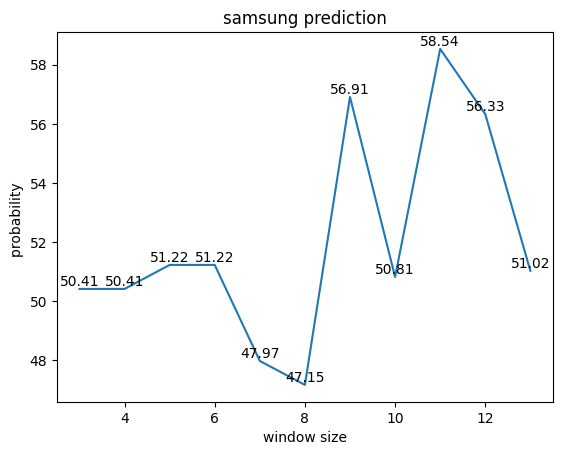

In [26]:
plt.plot(seq_list,accuracy_lst)
for i in range(len(accuracy_lst)):
    height = round(accuracy_lst[i],2)
    plt.text (seq_list[i],height,height, ha='center', va='bottom')
plt.title('samsung prediction')
plt.xlabel('window size')
plt.ylabel('probability ')
plt.show()

In [31]:
# torch.save(accuracy_lst,'./samsung_cnn,kospi')